# Display options

The display behaviour of **Gnuplot.jl** depends on the value of the `Gnuplot.options.gpviewer` boolean option:

- if `true` the plot is displayed in a gnuplot window, using one of the interactive terminals such as `wxt`, `qt` or `aqua`.  There is exactly one window for each session, and the plots are updated by replacing the displayed image.  The preferred terminal as well as its options can be set using `Gnuplot.options.term`;

- if `false` the plot is displayed through the Julia [multimedia interface](https://docs.julialang.org/en/v1/base/io-network/#Multimedia-I/O-1), i.e. it is exported as either a `png`, `svg` or `html` file, and displayed in an external viewer.  In this case the package is unable to replace a previous plot, hence each update results in a separate image being displayed.  The terminal options to export the images are set by re-defining the `show` method for a specific MIME type.

The latter approach is typically used when running a Jupyter, Pluto, VSCode or Juno session, while the former approach is appropriate in all cases (most notably, for the standard Julia REPL).  The `Gnuplot.options.gpviewer` flag is automatically set when the package is first loaded according to the runtime environment, however the user can change its value at any time to fit specific needs.  The following examples show the difference between the two approaches. 

Recall that the `:-` symbol has a special meaning in **Gnuplot.jl**:

- if given as first argument to a `@gp` or `@gsp` call, it append data and commands to a previously started plot.  To start a new plot omit `:-` as first arugment;
- if given as last argument it avoids updating the current plot, although data and commands are saved to be used at a later time.  To actually update a plot omit `:-` as last arugment.

The `:-` symbol has been chosen since it is reminiscent of hyphenation in natural language, and allows to split `@gp` and `@gsp` calls into multiple, possibly non-contiguous, statements.


## Display plots in a REPL session
Even if the following examples run in a notebook we can simulate a REPL session by explicitly setting `Gnuplot.options.gpviewer` to `true`:

In [1]:
using Gnuplot
Gnuplot.options.gpviewer = true; # simulate usage in a REPL

# Generate some numbers to plot
x = 1:0.1:10
y1 = sin.(x)
y2 = cos.(x)
y3 = y1.+y2;

Start a new plot using the `y1` dataset:

In [2]:
@gp x y1 "w l t 'sin'" :-

As expected, nothing is displayed since we used the `:-` symbol as last argument to `@gp`.
Now add a second dataset (`y2`), and omit the trailing `:-` symbol:

In [3]:
@gp :- x y2 "w l t 'cos'"

A new window should popup showing the plot with two datasets.  Now add a third dataset (`y3`):

In [4]:
@gp :- x y3 "w l t 'sin+cos' lw 2";

The plot has been updated by replacing the window content. The presence of the semicolon has no effect here, and the same applies when we involke `display()` on the returned value: 

In [5]:
display(ans)  # nothing happens here

Now insert the same `@gp` calls into a (possibly very long and complex) function, and invoke it:

In [6]:
function complex_function()
    # ...
    x = 1:0.1:10
    y1 = sin.(x)
    y2 = cos.(x)
    y3 = y1.+y2;
    @gp    :dummy x y1 "w l t 'sin'" :-
    @gp :- :dummy x y2 "w l t 'cos'"
    @gp :- :dummy x y3 "w l t 'sin+cos' lw 2";
    #...
    return nothing
end

complex_function()

Here we used a separate session called `dummy` to show the plot in a separate window.  Note that the same code used in the REPL or within a function generates the same plot.

To modify the terminal options when `gpviewer = true` you should set the `Gnuplot.options.term` appropriately, e.g.

In [7]:
Gnuplot.options.term = "wxt enhanced size 700,400 lw 3"  # <-- this applies only to newly created sessions
@gp :foo x y1 "w l t 'sin'"

## Display plots in an external viewer

Let's repeat the above examples redirecting the images on this notebook:

In [8]:
Gnuplot.options.gpviewer = false;  # use Julia multimedia interface

In [9]:
@gp x y1 "w l t 'sin'" :-

Again, the trailing `:-` symbol avoids creating a plot.  If we omit it:

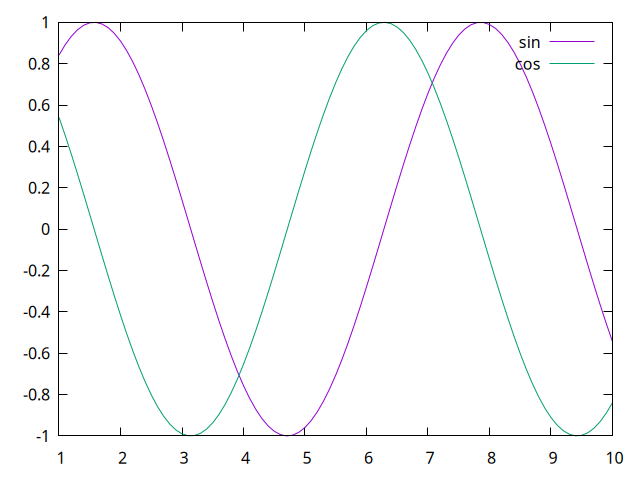

In [10]:
@gp :- x y2 "w l t 'cos'"

we obtain an inline plot with two datasets. Now the third dataset:

In [11]:
@gp :- x y3 "w l t 'sin+cos' lw 2";

According to the Julia convention, no plot is shown here since we added a trailing `;`, however all data have already been sent to gnuplot.

To display the updated plot we need an explicit call to `display()` on the returned value:

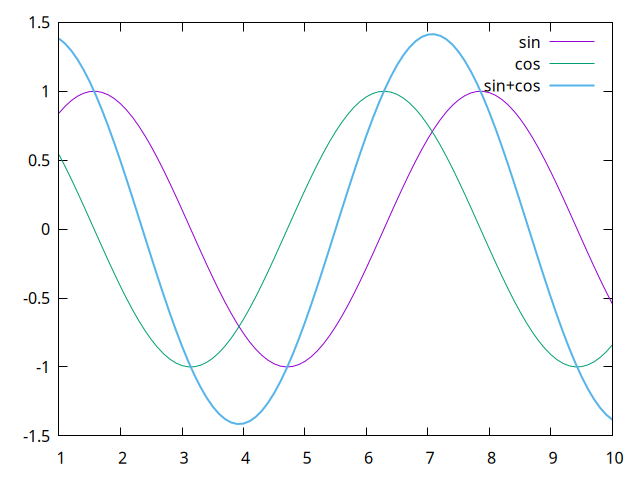

In [12]:
display(ans)

Unlike the previous case, note that the updated plot now appears in a separate image within the same notebook.

Now invoke the same code within the `complex_function()` function:

In [13]:
complex_function()

Unlike the previous case nothing appeared here since we need to explicitly invoke `display()` on the proper session:

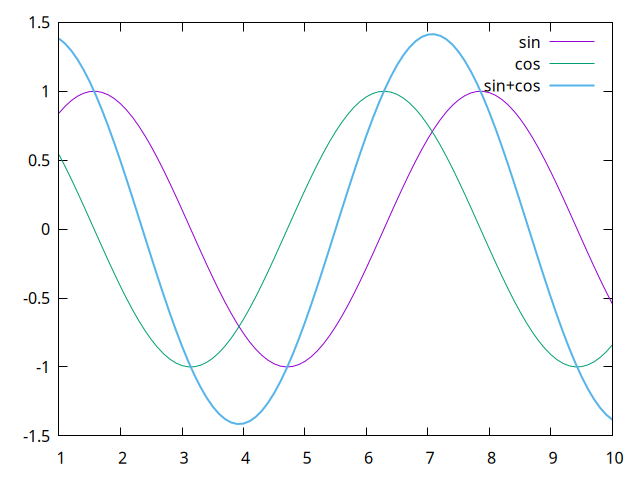

In [14]:
display(@gp :dummy)

Clearly, the plot appears in the same notebook (rather than in separate windows), even if the session is different.

## Customize `show()` methods

To modify the gnuplot terminal options when `gpviewer = false` you may redefine the `show` method for the preferred MIME type, e.g.

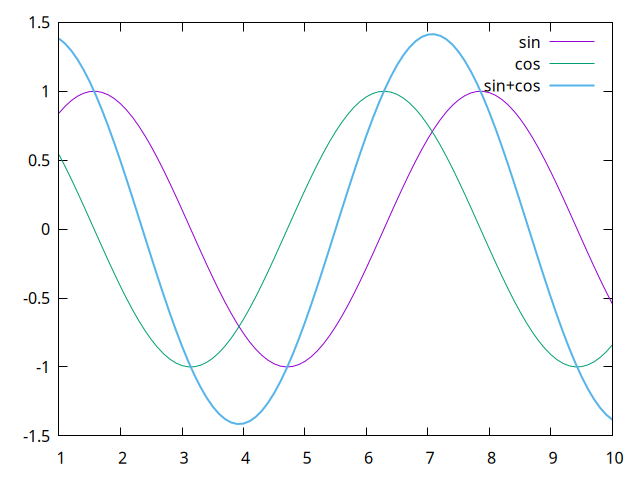

In [15]:
import Base.show
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced size 700,400 lw 3")
display(@gp :dummy)

Check your notebook viewer or IDE settings to identify the MIME used to render the images (`text/html` in the example above).

In some case, Jupyter stores plot in both rasterized and vector graphic formats (e.g. `png` and `svg+xml` within a notebook, making its size unecessary large. To force using a specific format you may delete the unnecessary `show()` methods with, e.g.
```julia
Base.delete_method(which(show, (IO, MIME"text/plain", Gnuplot.GPSession)))
Base.delete_method(which(show, (IO, MIME"text/html", Gnuplot.GPSession)))
Base.delete_method(which(show, (IO, MIME"image/svg+xml", Gnuplot.GPSession)))
```


## Summary

The following table summarizes the approaches discussed above:

| X                                                    | When `gpviewer = true`                    | When `gpviewer = false`                                             |
|------------------------------------------------------|-------------------------------------------|---------------------------------------------------------------------|
|                                                      | *(specific environment is not relevant)*  | *(depends on the environment)*                                      |
| **Plots are shown**                                  | In dedicated window(s).                   | REPL: using the `dumb` terminal;                                    |
|                                                      |                                           | Jupyter, Pluto: as inline images in the notebook;                   |
|                                                      |                                           | VSCode, Juno: as image in the plot pane.                            |
| **Updating a plot**                                  | Updates window content.                   | REPL: scroll the terminal;                                          |
|                                                      |                                           | Jupyter, Pluto: creates a separate image;                           |
|                                                      |                                           | VSCode, Juno: overwrites the plot pane content.                     |
| **Output of different sessions goes to**             | Separate windows.                         | REPL: same terminal;                                                |
|                                                      |                                           | Jupyter, Pluto: the same notebook;                                  |
|                                                      |                                           | VSCode, Juno: the same plot pane.                                   |
| **How many simultaneous plots can be shown?**        | All windows fitting the screen.           | REPL: all those fitting the scroll area;                            |
|                                                      |                                           | Jupyter, Pluto: all those fitting the visible part of the notebook; |
|                                                      |                                           | VSCode, Juno: only one (the plot pane).                             |
| **Calls to `display()`**                             | Does nothing.                             | Generates a new plot.                                               |
| **The top level code works also within a function?** | Yes, `display()` calls are not required.  | No, requires explicit `display()` calls.                            |
| **Terminal options are specified using**                | `Gnuplot.options.term`                    | (re-)definition of `show(::IO, ::MIME, ::GPSession)` methods.       |

